In [1]:
# Preamble
from astropy.table import Table, column, vstack
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

#### First task: load the required data and match up the catalogues

In [2]:
gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')

In [3]:
gz2_stats = Table.read('fits/gz2_statistics.fits')
sparcfire_matched = Table.read('fits/galaxy_level_matched.fits')
ml_table_matched = Table.read('fits/ml_table_matched.fits')

In [4]:
sample_ok = ml_table_matched['vmax_ok']
sparcfire_ok = sparcfire_matched['N_arcs'] > 0
print('{} in initial sample --> {} in sparcfire'.format(sample_ok.sum(),
                                         (sample_ok*sparcfire_ok).sum()))

sparcfire_sample_ok = np.all([sparcfire_ok,sample_ok],axis=0)

6222 in initial sample --> 3028 in sparcfire


#### First task = SpArcFire completeness plots...

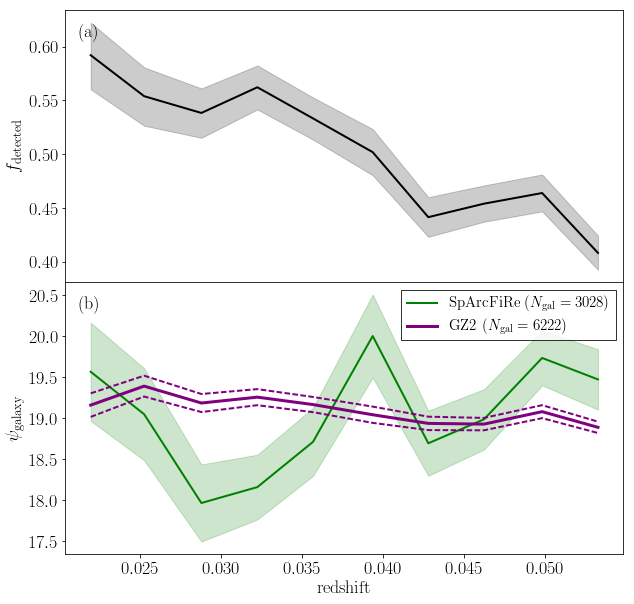

In [92]:
from bin_statistics import assign_bins, TableStats
from xy_plots import x_vs_y

import imp
imp.reload(xy_plots)
from xy_plots import x_vs_y

redshift = gz2_data['REDSHIFT_1'][sample_ok]
sparcfire_detected = sparcfire_ok[sample_ok]
sparcfire_sample = sparcfire_ok[sample_ok]

psi_sparcfire = sparcfire_matched['P_wtd_avg'][sample_ok][sparcfire_detected]
psi_gz2 = gz2_stats['psi_gz2'][sample_ok]

fig, axarr = plt.subplots(2,1,figsize=(10,10),
                          sharex=True)
fig.subplots_adjust(hspace=0,wspace=0)

ax = axarr[0]
#xy = x_vs_y(redshift,sparcfire_detected)
bins = assign_bins(redshift,N_bins=10,equal_N=False)
x = TableStats(redshift,bins).mean_and_error()['mean']
yf = TableStats(sparcfire_detected,bins).fraction_with_feature()
_ = ax.plot(x,yf['f'],color='k',lw=2)
_ = ax.fill_between(x,yf['f-0.683'],yf['f+0.683'],color='k',alpha=0.2)

ax = axarr[1]

bins_sparcfire = bins[sparcfire_detected]
y = TableStats(psi_sparcfire,bins_sparcfire).mean_and_error()
_ = ax.plot(x,y['mean'],color='g',lw=2,label='SpArcFiRe ($N_\mathrm{{gal}}={})$'.format(len(psi_sparcfire)))
_ = ax.fill_between(x,y['mean-1sigma'],y['mean+1sigma'],color='g',alpha=0.2)

xy = x_vs_y(redshift,psi_gz2)
xy.continuous_vs_continuous_binned_mean(bin_assignments=bins)
xy.line_plot(ax,color='purple',lw=3,label='GZ2 ($N_\mathrm{{gal}}={})$'.format(len(psi_gz2)))
xy.error_plot(ax,color='purple',lw=2,linestyle='dashed',style='lined')

_ = axarr[0].text(0.025,0.95,'(a)',
                  transform=axarr[0].transAxes,ha='left',va='top')
_ = axarr[1].text(0.025,0.95,'(b)',
                  transform=axarr[1].transAxes,ha='left',va='top')

_ = axarr[0].set_ylabel('$f_\mathrm{detected}$')
_ = axarr[1].legend(fontsize=15,edgecolor='k',fancybox=False)
_ = axarr[1].set_xlabel('redshift')
_ = axarr[1].set_ylabel('$\psi_\mathrm{galaxy}$')

#xy.error_plot(ax,color='purple',lw=1,linestyle='dotted',style='lined',plus=7)
_ = fig.savefig('paper_figures/z_vs_fP.pdf')

In [93]:
print(yf)

      f           f-0.683        f+0.683    
-------------- -------------- --------------
         0.592 0.560284166654 0.622253734459
0.553892215569 0.526434158564 0.580708043786
 0.53829787234 0.515173618436 0.561097292157
0.562180579216 0.541513241269 0.582425314401
0.533230293663 0.513531758371 0.552723869216
0.501851851852 0.480354558148 0.523335467884
0.441379310345 0.423112328294 0.459969053718
0.453917050691 0.437132575662 0.470913540607
0.463819691578 0.446738806036 0.481071958558
0.408141962422  0.39245975013  0.42420716019


In [94]:
gz2_stats['p_bar'] = gz2_data['t03_bar_a06_bar_debiased_rh']
# define some classes:
# 1 = m=2, unbarred
# 2 = m=2, barred
# 3 = m>2, unbarred
# 4 = m>2, barred

plot_class = np.zeros(len(gz2_stats))
plot_class[(gz2_stats['m'] == 2) 
         & (gz2_stats['p_bar'] <= 0.5)] = 1
plot_class[(gz2_stats['m'] == 2) 
         & (gz2_stats['p_bar'] > 0.5)] = 2
plot_class[(gz2_stats['m'] > 2) 
         & (gz2_stats['p_bar'] <= 0.5)] = 3
plot_class[(gz2_stats['m'] > 2) 
         & (gz2_stats['p_bar'] > 0.5)] = 4

gz2_stats['plot_class'] = plot_class

#### First task: what do the pitch angle distributions _look_ like?

In [95]:
# Get some galaxy distributions to compare to

s4g_galaxies = Table.read('../fits/S4G/s4g_arms_galaxy.fits')
s4g_psi = np.array(s4g_galaxies['P_abs'])

seigar_06 = [8.4,25.2,25.7,18,26.4,46.4,17.6,31.1,15.7,50.3,31.7,48.8,42.1,
             20.3,26.4,46.9,10.7,21.2,13.6,24,28.1,32.5,21.7,15.3,32,31,
             24.9,18.2,35.7,19.8,18.3,43.3,13.2,24.8,22.1,32.1,40.4,22.4,
             17.8,49.3,16.3,49.5,38.7,29.6,25.1,36.7,40.4,26.2,17.8,20.3,
             24.9,29.4,22.3,17.8,19.3,16.1,28.5,
             38.8,13.8,27.6,24.2,24,14.1,36.9,9.1,8.9]

[ 11.80299854  16.63929558  23.54610062]
[ 12.76565479  19.48719597  28.17950081]
[ 12.06997032  18.55647469  26.35439072]
[ 13.69501495  19.22007751  27.16614342]


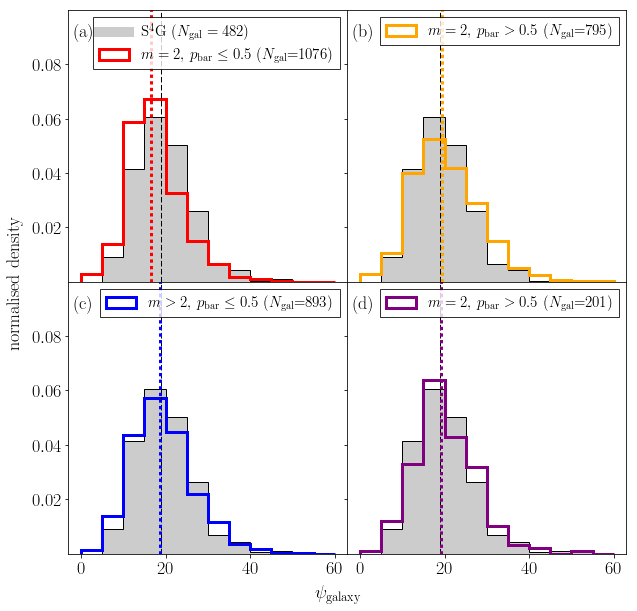

In [97]:
fig, axarr = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)
axarr = axarr.ravel()
fig.subplots_adjust(hspace=0,wspace=0)

colors = ('red','orange','blue','purple')
classlabels = ('$m=2$, $p_\mathrm{bar} \leq 0.5$',
               '$m=2$, $p_\mathrm{bar} > 0.5$',
               '$m>2$, $p_\mathrm{bar} \leq0.5$',
               '$m=2$, $p_\mathrm{bar} > 0.5$')
letters = 'abcd'

bins = np.linspace(0,60,13)

###############################

_ = axarr[0].plot([],[],color='k',alpha=0.2,lw=10,
            label='S$^4$G ($N_\mathrm{{gal}}={}$)'.format(len(s4g_psi))) 

for c, (ax, color) in enumerate(zip(axarr,colors)):
    plt.sca(ax)
    in_class = np.all([sparcfire_sample_ok,gz2_stats['plot_class'] == c+1],
                      axis=0)
    psi_c = sparcfire_matched['P_wtd_avg'][in_class]
    _ = ax.hist(s4g_psi,bins,normed=True,color='k',alpha=0.2,
                histtype='stepfilled')
    _ = ax.hist(s4g_psi,bins,normed=True,color='k',histtype='step')
    plt.axvline(np.median(s4g_psi),color='k',linestyle='dashed',lw=1)
    c_label = classlabels[c] + ' ($N_\mathrm{{gal}}$={})'.format(in_class.sum())
    _ = ax.hist(psi_c,bins,normed=True,color=color,histtype='step',lw=3,
                label=c_label)
    plt.axvline(np.median(psi_c),color=color,linestyle='dotted',lw=3)
    ax.legend(loc='upper right',fancybox=False,edgecolor='k',fontsize=15)
    _ = ax.text(0.02,0.95,'({})'.format(letters[c]),
                transform=ax.transAxes,ha='left',va='top')
    print(np.percentile(psi_c,(16,50,84)))

_ = ax.set_ylim(0,0.1)   
_ = fig.text(0.5, 0.06, '$\psi_\mathrm{galaxy}$', ha='center')
_ = fig.text(0.04, 0.5, 'normalised density', va='center', rotation='vertical')

_ = fig.savefig('paper_figures/pitch_angle_histograms.pdf')

In [98]:
psi = sparcfire_matched['P_wtd_avg'][sparcfire_sample_ok]
f10 = (psi < 10).sum()/len(psi)
f40 = (psi > 40).sum()/len(psi)
print(f10,f40)

0.0756274768824 0.0112285336856


In [99]:
print('S4G:')
print(np.percentile(s4g_psi,(16,50,84)))

print('all galaxies:')
print(np.percentile(sparcfire_matched['P_wtd_avg'][sparcfire_sample_ok],
      (16,50,84)))

S4G:
[ 13.498668  18.96335   25.733684]
all galaxies:
[ 12.17640102  18.00815773  26.12333389]


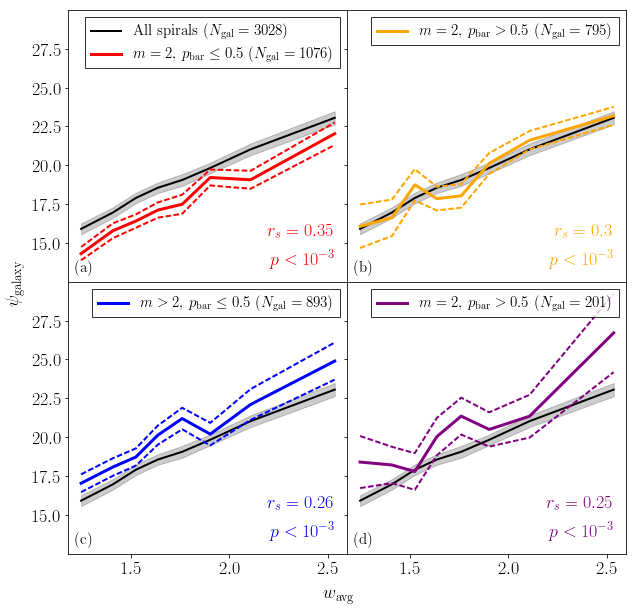

In [100]:
import xy_plots
import imp
imp.reload(xy_plots)

from bin_statistics import assign_bins
from xy_plots import x_vs_y

fig, axarr = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)
axarr = axarr.ravel()
fig.subplots_adjust(hspace=0,wspace=0)

###############################
sample_bins = assign_bins(gz2_stats['w_wtd_avg'][sparcfire_sample_ok],
                          equal_N=True,N_bins=8)
galaxy_bins = np.zeros(len(gz2_stats))
galaxy_bins[sparcfire_sample_ok] = sample_bins

xy_all = x_vs_y(gz2_stats['w_wtd_avg'][sparcfire_sample_ok],
                sparcfire_matched['P_wtd_avg'][sparcfire_sample_ok])
xy_all = xy_all.continuous_vs_continuous_binned_mean(bin_assignments=sample_bins)

axarr[0].plot([],[],color='k',lw=2,
    label='All spirals ($N_\mathrm{{gal}}={}$)'.format(sparcfire_sample_ok.sum()))

for c, (ax, color, label) in enumerate(zip(axarr,colors,classlabels)):
    xy_all.line_plot(ax,color='k',lw=2)
    xy_all.error_plot(ax,color='k',style='filled',alpha=0.2)
    
    in_class = np.all([gz2_stats['plot_class'] == c+1,sparcfire_sample_ok],
                      axis=0)
    class_bins = galaxy_bins[in_class]
    
    xy_label = label + ' ($N_\mathrm{{gal}}={}$)'.format(in_class.sum())
    xy = x_vs_y(gz2_stats['w_wtd_avg'][in_class],
                sparcfire_matched['P_wtd_avg'][in_class])
    xy = xy.continuous_vs_continuous_binned_mean(bin_assignments=class_bins)
    xy.x_table = xy_all.x_table # for plotting
    xy.line_plot(ax,color=color,lw=3,label=xy_label)
    xy.error_plot(ax,style='lined',linestyle='dashed',lw=2,color=color)
    xy.spearmanr(ax,location='lower right',color=color,spacing=0.1)
    ax.legend(loc='upper right',fontsize=15,fancybox=False,edgecolor='k')
    ax.text(0.025,0.025,'({})'.format(letters[c]),fontsize=15,
            transform=ax.transAxes,va='bottom',ha='left')

_ = fig.text(0.5, 0.06,'$w_\mathrm{avg}$', ha='center')
_ = fig.text(0.04, 0.5,r'$\psi_\mathrm{galaxy}$', va='center', rotation='vertical')
_ = ax.set_ylim(12.5,30)

fig.savefig('paper_figures/w_avg_vs_P.pdf')

In [101]:
print(xy_all.spearmanr(None,plot=False,printout=True))

$r_s = 0.3$ $p < 10^{-3}$
('$r_s = 0.3$', '$p < 10^{-3}$')


#### Next task: compare spiral arm number and pitch angle?

Here, we shall use the M*-matched sample

In [102]:
mass_masks = Table.read('fits/mass_masks_matched.fits')

names_ = mass_masks.colnames[3:]

# ------------------------------------------------------
mass_0 = np.any([mass_masks[n] for n in names_],axis=0)
bar_0 = np.all([sparcfire_sample_ok,mass_0],axis=0)
print(bar_0.sum())
# ------------------------------------------------------
mass_1 = np.any([mass_masks[n] for n in names_[:5]],axis=0)
bar_1 = np.all([sparcfire_sample_ok,mass_1],axis=0)
print(bar_1.sum())
# ------------------------------------------------------
mass_2 = np.any([mass_masks[n] for n in names_[5:10]],axis=0)
bar_2 = np.all([sparcfire_sample_ok,mass_2],axis=0)
print(bar_2.sum())
# ------------------------------------------------------
mass_3 = np.any([mass_masks[n] for n in names_[10:15]],axis=0)
bar_3 = np.all([sparcfire_sample_ok,mass_3],axis=0)
print(bar_3.sum())
# ------------------------------------------------------

masks = [bar_0,bar_1,bar_2,bar_3]

2365
914
781
670


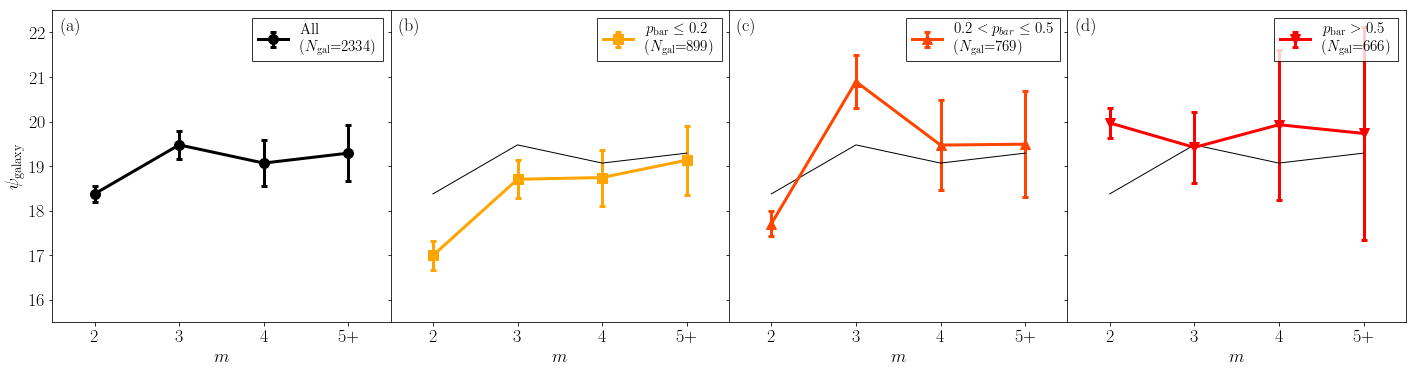

In [103]:
import imp
imp.reload(xy_plots)
from xy_plots import x_vs_y

fig, axarr = plt.subplots(1,4,figsize=(20,5.5),
                          sharex='row',sharey='row')

colors = ('black','orange','orangered','red')
markers = ('o','s','^','v')
ticklabels = ('1','2','3','4','5+')
letters = 'abcdef'
xys = []

classlabels = ('All','$p_\mathrm{bar} \leq 0.2$',
               '$0.2 < p_{bar} \leq 0.5$', '$p_\mathrm{bar} > 0.5$')

mask_all = (masks[0]) & (gz2_stats['m'] > 1)
xy_all = x_vs_y(gz2_stats['m'][mask_all],
                sparcfire_matched['P_wtd_avg'][mask_all])
xy_all = xy_all.discrete_vs_continuous_binned_mean()
for ax in axarr:
    xy_all.line_plot(ax,color='k',lw=1)

for mask, label, ax, color, marker, letter in zip(masks,classlabels,axarr,colors,markers,letters):
    mask_ = (mask) & (gz2_stats['m'] > 1)
    
    xy = x_vs_y(gz2_stats['m'][mask_],
                sparcfire_matched['P_wtd_avg'][mask_])
    xy = xy.discrete_vs_continuous_binned_mean()
    xy_label = label + '\n ($N_\mathrm{{gal}}$={})'.format(mask_.sum())
    xy.error_plot(ax,color=color,style='errorbar',marker=marker,
                  markersize=10,lw=3,capsize=3,capthick=3,label=xy_label)
    #xy.spearmanr(ax,location='lower right',spacing=0.1)
    ax.legend(loc='upper right',fontsize=15,fancybox=False,edgecolor='k')
    ax.text(0.025,0.975,'({})'.format(letter),
            transform=ax.transAxes,ha='left',va='top')
    _ = ax.set_xlabel('$m$')
    xys.append(xy)
    
_ = axarr[0].set_xlim(1.5,5.5)
_ = axarr[0].set_xticks([2,3,4,5])
_ = axarr[0].set_xticklabels(ticklabels[1:])
_ = axarr[0].set_ylabel(r'$\psi_\mathrm{galaxy}$')

fig.tight_layout()
fig.subplots_adjust(wspace=0,hspace=0)
_ = ax.set_ylim(15.5,22.5)

fig.savefig('paper_figures/m_vs_P.pdf')

In [104]:
for b in range(4):

    print(xys[b].y_table['mean'],
          xys[b].y_table['mean']-xys[b].y_table['mean-1sigma'])
    
    print('------------------------')

     mean    
-------------
 18.374285964
19.4754414521
19.0670630537
19.2901895726      mean     
--------------
0.185011008871
0.321052817984
0.512939118104
0.632871887076
------------------------
     mean    
-------------
16.9915209987
18.7029082398
18.7424516305
19.1320435642      mean     
--------------
0.322388219685
0.425764202576
0.628171625967
 0.77426564141
------------------------
     mean    
-------------
17.7031090737
20.8964384376
19.4712713118
19.4912510933      mean     
--------------
0.282088375483
0.593643811897
 1.01953323408
 1.18433462926
------------------------
     mean    
-------------
19.9692797755
19.4189233581
19.9283445941
19.7333794393      mean     
--------------
0.330494397681
0.802445775181
 1.68203051899
 2.39547023966
------------------------


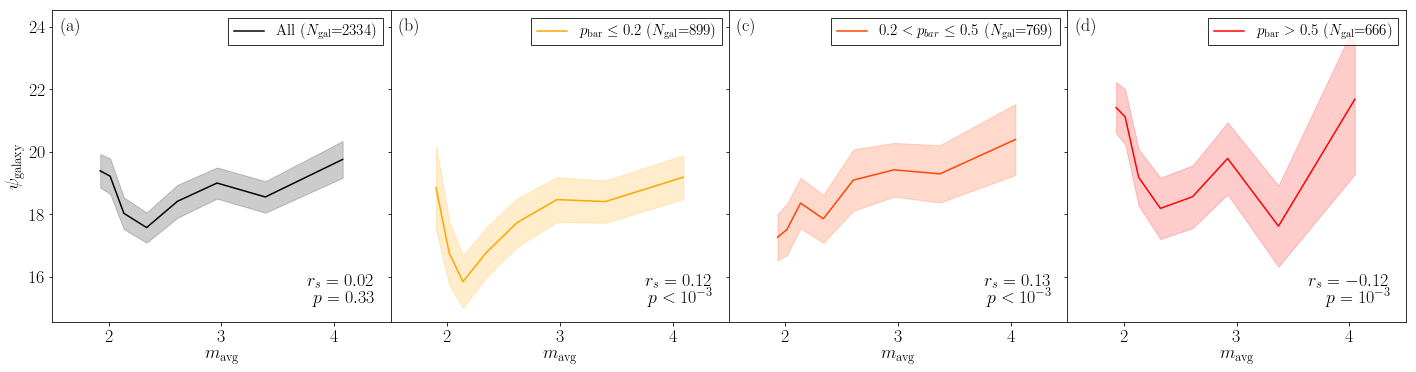

In [108]:
from bin_statistics import assign_bins

fig, axarr = plt.subplots(1,4,figsize=(20,5.5),sharex='row',sharey='row')


mask_all = (masks[0]) & (gz2_stats['m'] > 1)
bins_ = assign_bins(gz2_stats['m_wtd_avg'][mask_all],N_bins=8)
all_bins = np.ones(len(gz2_data))*(-999)
all_bins[mask_all] = bins_


for mask, label, ax, color, letter in zip(masks,classlabels,axarr,colors,letters):
    mask_ = (mask) & (gz2_stats['m'] > 1)
    #mask_ = mask
    xy = x_vs_y(gz2_stats['m_wtd_avg'][mask_],
                sparcfire_matched['P_wtd_avg'][mask_])
    
    x = gz2_stats['m_wtd_avg'][mask_]
    y = sparcfire_matched['P_wtd_avg'][mask_]
    bins = all_bins[mask_]
    xy_label = label + ' ($N_\mathrm{{gal}}$={})'.format(mask_.sum())
    xy.spearmanr(ax,location='lower right')
    x_plot = []
    y_plot = []
    y_err = []
    for b in np.unique(bins):
        x_plot.append(np.mean(x[bins == b]))
        y_plot.append(np.mean(y[bins == b]))
        y_err.append(1.253*np.std(y[bins==b])/np.sqrt((bins == b).sum()))
    x_plot = np.array(x_plot)
    y_plot = np.array(y_plot)
    y_err = np.array(y_err)
    
    _ = ax.plot(x_plot,y_plot,
                color=color,label=xy_label)
    _ = ax.fill_between(x_plot,y_plot-y_err,y_plot+y_err,
                        color=color,alpha=0.2)
    
    ax.legend(loc='upper right',fontsize=15,fancybox=False,edgecolor='k')
    _ = ax.set_xlabel('$m_\mathrm{avg}$')
    
    ax.text(0.025,0.975,'({})'.format(letter),
            transform=ax.transAxes,ha='left',va='top')
    
_ = axarr[0].set_xlim(1,5)
_ = axarr[0].set_xticks([2,3,4])
_ = axarr[0].set_ylabel(r'$\psi_\mathrm{galaxy}$')

fig.tight_layout()
fig.subplots_adjust(wspace=0,hspace=0)
ax.set_xlim(1.5,4.5)

fig.savefig('paper_figures/m_avg_vs_P.pdf')

In [109]:
for b in range(3):

    print(xys[b].y_table['mean'],
          xys[b].y_table['mean']-xys[b].y_table['mean-1sigma'])
    
    print('------------------------')

     mean    
-------------
 18.374285964
19.4754414521
19.0670630537
19.2901895726      mean     
--------------
0.185011008871
0.321052817984
0.512939118104
0.632871887076
------------------------
     mean    
-------------
16.9915209987
18.7029082398
18.7424516305
19.1320435642      mean     
--------------
0.322388219685
0.425764202576
0.628171625967
 0.77426564141
------------------------
     mean    
-------------
17.7031090737
20.8964384376
19.4712713118
19.4912510933      mean     
--------------
0.282088375483
0.593643811897
 1.01953323408
 1.18433462926
------------------------


#### Final task: how does the presence of a bar affect the spiral arm pitch angle?

$r_s = 0.12$ $p < 10^{-3}$
$r_s = 0.2$ $p < 10^{-3}$


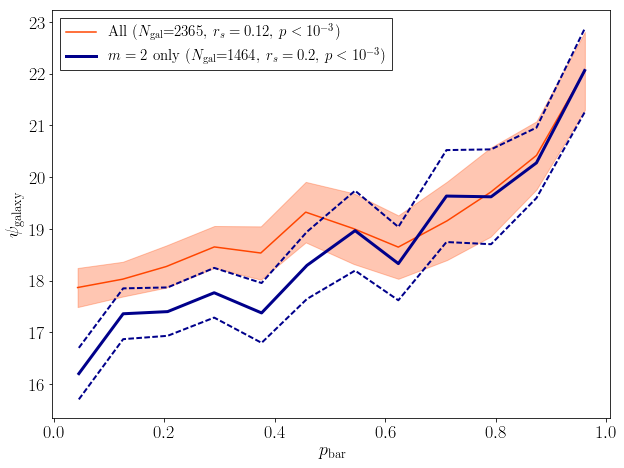

In [110]:
fig = plt.figure(figsize=(10,7.5))
ax = plt.subplot(111)

bar_sample_matched = np.all([sparcfire_sample_ok,bar_0],axis=0)
m_2_sparcfire_ok = np.all([gz2_stats['m'] == 2,bar_sample_matched],
                          axis=0)

x_all = gz2_stats['p_bar'][bar_sample_matched]
y_all = sparcfire_matched['P_wtd_avg'][bar_sample_matched]
m_2 = gz2_stats['m'][bar_sample_matched] == 2

galaxy_bins = assign_bins(gz2_stats['p_bar'][bar_sample_matched],
                          equal_N=False,N_bins=12)

xy_all = x_vs_y(x_all,y_all)
xy_all = xy_all.continuous_vs_continuous_binned_mean(bin_assignments=galaxy_bins)
r_all, s_all = xy_all.spearmanr(ax,printout=True,plot=False)
xy_all_label='All ($N_\mathrm{{gal}}$={}, {}, {})'.format(len(x_all),r_all,s_all)
xy_all.line_plot(ax,color='orangered',label=xy_all_label)
xy_all.error_plot(ax,color='orangered',alpha=0.3,style='filled')


xy_m_2 = x_vs_y(x_all[m_2],y_all[m_2])
xy_m_2 = xy_m_2.continuous_vs_continuous_binned_mean(bin_assignments=galaxy_bins[m_2])
r_2, s_2 = xy_m_2.spearmanr(ax,printout=True,plot=False)
xy_m_2_label='$m=2$ only ($N_\mathrm{{gal}}$={}, {}, {})'.format(m_2.sum(),r_2,s_2)
xy_m_2.line_plot(ax,color='darkblue',lw=3,label=xy_m_2_label)
xy_m_2.error_plot(ax,color='darkblue',style='lined',linestyle='dashed',lw=2)

_ = ax.legend(loc='upper left',fontsize=15,fancybox=False,edgecolor='k')

_ = ax.set_xlabel('$p_\mathrm{bar}$')
_ = ax.set_ylabel('$\psi_\mathrm{galaxy}$')

fig.savefig('paper_figures/p_bar_vs_P.pdf')

In [114]:
print(xy_all.y_table)
print('-----------------------------------------\n')
print(xy_m_2.y_table)

     mean      mean-1sigma   mean+1sigma 
------------- ------------- -------------
17.8678904645 17.4904023888 18.2453785402
18.0298816817 17.6942446708 18.3655186926
18.2742699559 17.8672437314 18.6812961805
18.6526620501 18.2482127747 19.0571113254
18.5349990439 18.0202530014 19.0497450864
 19.324774382 18.7402256142 19.9093231499
19.0061285064  18.323470709 19.6887863038
18.6490734582 18.0366299473  19.261516969
 19.157385822 18.3999393897 19.9148322543
19.7094930385  18.849532364  20.569453713
20.4212137945  19.761904336  21.080523253
22.0522868195 21.2972760147 22.8072976242
-----------------------------------------

     mean      mean-1sigma   mean+1sigma 
------------- ------------- -------------
16.2043205102 15.7066678877 16.7019731328
17.3610793724 16.8703882421 17.8517705028
17.4026406884 16.9351147764 17.8701666004
17.7672588454 17.2870704537 18.2474472372
17.3772835978 16.7992659514 17.9553012442
18.2962763508  17.647211326 18.9453413756
18.9673568109 18.1956350035 19.73

In [35]:
import imp
imp.reload(xy_plots)

import xy_plots
from xy_plots import x_vs_y